# Задание
* Cкачайте все вакансии СБЕРа из api hh.ru (https://github.com/hhru/api у апи есть ограничение в 2000, подумайте как его обойти)
* Извлеките все полные описания этих вакансий по запросу с https://api.hh.ru/vacancies/43326020 где 43326020 id вакансии
* Создайте DataFrame в котором будут даты публикации вакансий, названия, описания,  только добавьте поле ключевые навыки
* Переведите даты публикаций в формат datetime и постройте график опубликованных вакансий по датам
* Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
* Найдите вакансии с использованием python, которые вам интересны
* Определите по полю с ключевыми навыками, какие навыки больше всего востребованы для найденных вакансий
* Постройте график наиболее востребованных навыков

In [1]:
import requests
from tqdm.auto import tqdm

In [2]:
sber = '3529'
page = 1
num_per_page = 100
moscow = 1
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}' #&area={moscow}

In [3]:
res = requests.get(url)
vacancies = res.json()
num_pages = vacancies.get('pages')
num_pages

20

In [4]:
vacancies = res.json()
num_pages = vacancies.get('pages')
vacancy_ids = [el.get('id') for el in vacancies.get('items')]

In [7]:
all_vacancy_ids= []
for i in tqdm(range(vacancies.get('pages'))):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={i}&per_page={num_per_page}' #&area={moscow}
    res = requests.get(url)
    vacancies = res.json()
    vacancy_ids = [el.get('id') for el in vacancies.get('items')]
    all_vacancy_ids.extend(vacancy_ids)

In [45]:
# Я дважды запускал эту ячейку - в первый раз до 139 записи, а второй - до конца списка вакансий

import time

#data = []
for i in tqdm(range(len(data), len(all_vacancy_ids))):
    url = f'https://api.hh.ru/vacancies/{all_vacancy_ids[i]}'
    res = requests.get(url)
    if 'errors' in res.json():
        print(f'Индекс необработанной вакансии: {i}')
        break
    data.append(res.json())
    time.sleep(10)

In [184]:
len(data)

2000

In [48]:
dates = [i['published_at'] for i in data]
names = [i['name'] for i in data]
descriptions = [i['description'] for i in data]
skills = [i['key_skills'] for i in data]

In [82]:
import pandas as pd
df = pd.DataFrame(
    {'date': dates,
     'name': names,
     'description': descriptions,
     'key_skills': skills
    })

In [90]:
df.tail()

,date,name,description,key_skills,weekday
1995,2023-02-20,Старший менеджер по обслуживанию (д. Новые Мур...,<p>Сбер — это 14 тысяч подразделений и лучший ...,[],0
1996,2023-02-17,Кредитный инспектор корпоративного канала,<p>Сбер — лучший работодатель России. У нас бо...,[],4
1997,2023-02-19,Ведущий инженер по сопровождению,"<p>Мы ищем Support Data Engineer, имеющего мат...",[],6
1998,2023-03-17,Аналитик / Руководитель направления в отдел ко...,<p><strong>Обязанности:</strong></p> <ul> <li>...,[],4
1999,2023-03-14,"Старший менеджер по обслуживанию, г.Тула",<p>Мы ищем старших менеджеров по обслуживанию ...,[],1


In [51]:
df.to_csv('vacancies.csv')

In [84]:
# Переведите даты публикаций в формат datetime

from datetime import datetime

df['date'] =  pd.to_datetime(df['date'], format = '%Y-%m-%dT%H:%M:%S%z', errors='coerce').dt.date

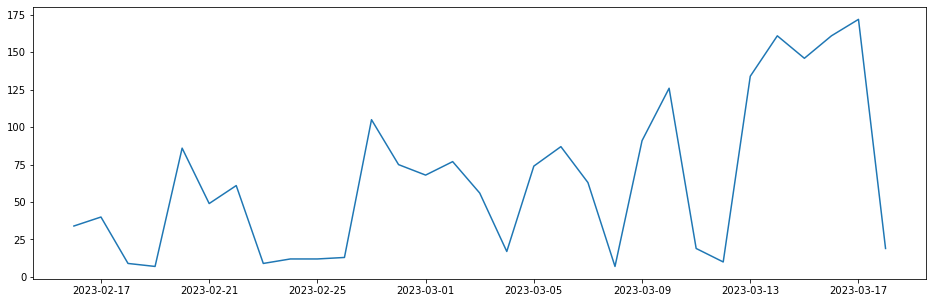

In [86]:
# Постройте график опубликованных вакансий по датам

import matplotlib.pyplot as plt

df2 = df.groupby(['date'])['date'].count()

plt.figure(figsize = (16, 5))
plt.plot(df2.index, df2)
plt.show()


In [92]:
# Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий

df['weekday'] = pd.to_datetime(df['date'], errors = 'coerce').dt.dayofweek
df3 = df.groupby(['weekday'])['weekday'].count()
print('Больше всего вакансий публикуют в понедельник')
df3.head(7)

Больше всего вакансий публикуют в понедельник


weekday
0    412
1    348
2    282
3    372
4    406
5     76
6    104
Name: weekday, dtype: int64

In [173]:
# Найдите вакансии с использованием python, которые вам интересны

mask = df['description'].str.contains('исследова') & ~(df['name'].str.contains('тажер')) & ~(df['name'].str.contains('изайнер')) \
    & ~(df['name'].str.contains('разработчик')) & ~(df['name'].str.contains('eveloper')) & ~(df['name'].str.contains('енеджер')) \
    & ~(df['name'].str.contains('хранник')) & ~(df['name'].str.contains('нженер')) & ~(df['description'].str.lower().str.contains('python'))

print(f'Найдены {df[mask].shape[0]} интересных мне вакансии, в которых упоминается Python')

Найдены 42 интересных мне вакансии, в которых упоминается Python


In [176]:
# Определите по полю с ключевыми навыками, какие навыки больше всего востребованы для найденных вакансий

from collections import Counter

x = list(df[mask]['key_skills'].apply(pd.Series).stack().reset_index(drop = True))
res = Counter([d['name'] for d in x]).most_common()
df4 = pd.DataFrame(res, columns = ['skill', 'num'])
df4.head()

,skill,num
0,Figma,3
1,Английский язык,3
2,BPMN,3
3,UX,2
4,MS PowerPoint,2


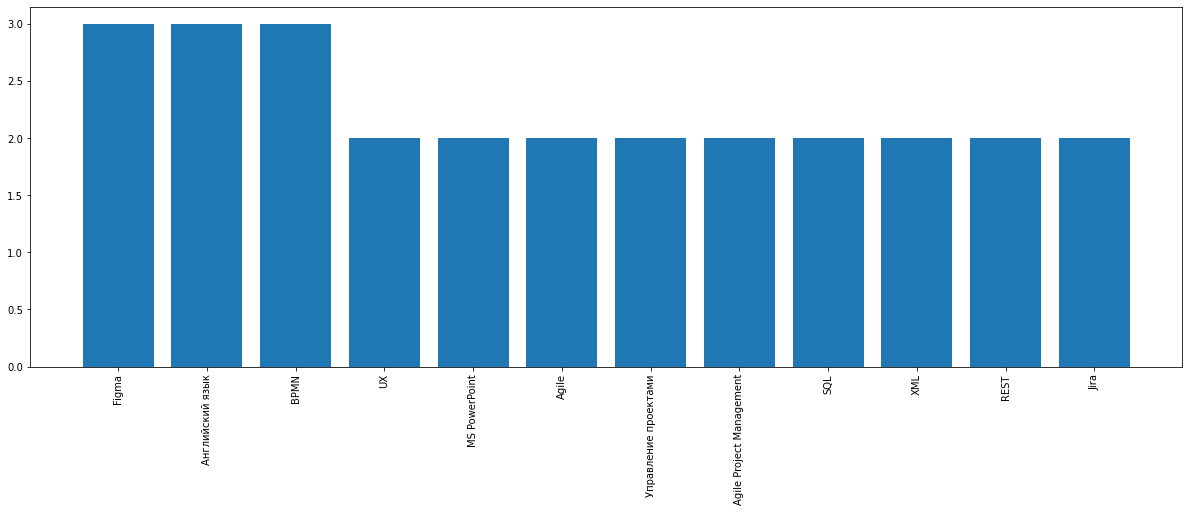

In [183]:
# Постройте график наиболее востребованных навыков - я опустил те навыки, которые встречаются только один раз

fig = plt.figure(figsize = (16, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(df4[df4['num'] > 1]['skill'], df4[df4['num'] > 1]['num'])
plt.xticks(rotation = 90)
plt.show()